In [1]:
import os
import pathlib
import sys
import time

import numpy as np
import pandas as pd
import psutil
from arg_parsing_utils import check_for_missing_args, parse_args
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

from loading_classes import ImageSetLoader, ObjectLoader
from neighbors_utils import (
    classify_cells_into_shells,
    create_results_dataframe,
    get_coordinates,
    measure_3D_number_of_neighbors,
    plot_distance_distributions,
    visualize_organoid_shells,
)
from notebook_init_utils import bandicoot_check, init_notebook
from resource_profiling_util import get_mem_and_time_profiling

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
if not in_notebook:
    arguments_dict = parse_args()
    patient = arguments_dict["patient"]
    well_fov = arguments_dict["well_fov"]
    channel = arguments_dict["channel"]
    compartment = arguments_dict["compartment"]
    processor_type = arguments_dict["processor_type"]
    input_subparent_name = arguments_dict["input_subparent_name"]
    mask_subparent_name = arguments_dict["mask_subparent_name"]
    output_features_subparent_name = arguments_dict["output_features_subparent_name"]

else:
    well_fov = "D4-1"
    patient = "NF0016_T1"
    channel = "DNA"
    compartment = "Nuclei"
    processor_type = "CPU"
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"
    output_features_subparent_name = "extracted_features"

image_set_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}/"
)
mask_set_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}/"
)
output_parent_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{output_features_subparent_name}/{well_fov}/"
)
output_parent_path.mkdir(parents=True, exist_ok=True)

In [3]:
channel_n_compartment_mapping = {
    "DNA": "405",
    "AGP": "488",
    "ER": "555",
    "Mito": "640",
    "BF": "TRANS",
    "Nuclei": "nuclei_",
    "Cell": "cell_",
    "Cytoplasm": "cytoplasm_",
    "Organoid": "organoid_",
}

In [4]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [5]:
image_set_loader = ImageSetLoader(
    image_set_path=image_set_path,
    mask_set_path=mask_set_path,
    anisotropy_spacing=(1, 0.1, 0.1),
    channel_mapping=channel_n_compartment_mapping,
)

In [6]:
# loop through each compartment and channel
# and measure the number of neighbors
# for each compartment

compartment = "Nuclei"
channel = "DNA"
object_loader = ObjectLoader(
    image_set_loader.image_set_dict[channel],
    image_set_loader.image_set_dict[compartment],
    channel,
    compartment,
)
neighbors_out_dict = measure_3D_number_of_neighbors(
    object_loader=object_loader,
    distance_threshold=10,
    anisotropy_factor=image_set_loader.anisotropy_factor,
)
final_df = pd.DataFrame(neighbors_out_dict)

In [7]:
# PARAMETERS - Adjust these as needed
N_SHELLS = 4
METHOD = "mahalanobis"  # 'mahalanobis' or 'euclidean'
RANDOM_SEED = 42

In [8]:
organoid_loader = ObjectLoader(
    image_set_loader.image_set_dict[channel],
    image_set_loader.image_set_dict["Organoid"],
    channel,
    compartment,
)
nuclei_loader = ObjectLoader(
    image_set_loader.image_set_dict[channel],
    image_set_loader.image_set_dict["Nuclei"],
    channel,
    compartment,
)
organoid_mask = image_set_loader.image_set_dict["Organoid"]
nuclei_mask = image_set_loader.image_set_dict["Nuclei"]
# get nuclei masks that are only in the organoid
object_ids_dict = {}
for organoid_id in organoid_loader.object_ids:
    object_ids_dict[organoid_id] = []
    organoid_mask_instance = organoid_mask.copy()
    organoid_mask_instance[organoid_mask_instance != organoid_id] = 0
    organoid_mask_instance[organoid_mask_instance == organoid_id] = 1
    # get only nulcei objects that are within the organoid
    for nuclei_id in nuclei_loader.object_ids:
        nuclei_mask_instance = nuclei_mask.copy()
        nuclei_mask_instance[nuclei_mask_instance != nuclei_id] = 0
        nuclei_mask_instance[nuclei_mask_instance == nuclei_id] = 1
        # check if any overlap
        overlap = np.logical_and(organoid_mask_instance, nuclei_mask_instance)
        if np.sum(overlap) > 0:
            object_ids_dict[organoid_id].append(nuclei_id)

Processing organoid ID: 2 with 0 nuclei
Processing organoid ID: 3 with 4 nuclei
           Reducing to 2 shells for statistical reliability
Processing organoid ID: 6 with 4 nuclei
           Reducing to 2 shells for statistical reliability
Processing organoid ID: 17 with 1 nuclei
           Reducing to 2 shells for statistical reliability
Processing organoid ID: 24 with 7 nuclei


/home/lippincm/miniforge3/envs/GFF_featurization/lib/python3.12/site-packages/neighbors_utils.py:373: RuntimeWarning: invalid value encountered in divide
  normalized_distances = distances / max_distance
/home/lippincm/miniforge3/envs/GFF_featurization/lib/python3.12/site-packages/neighbors_utils.py:376: RuntimeWarning: invalid value encountered in cast
  shell_assignments = numpy.floor(normalized_distances * n_shells).astype(int)


           Reducing to 2 shells for statistical reliability


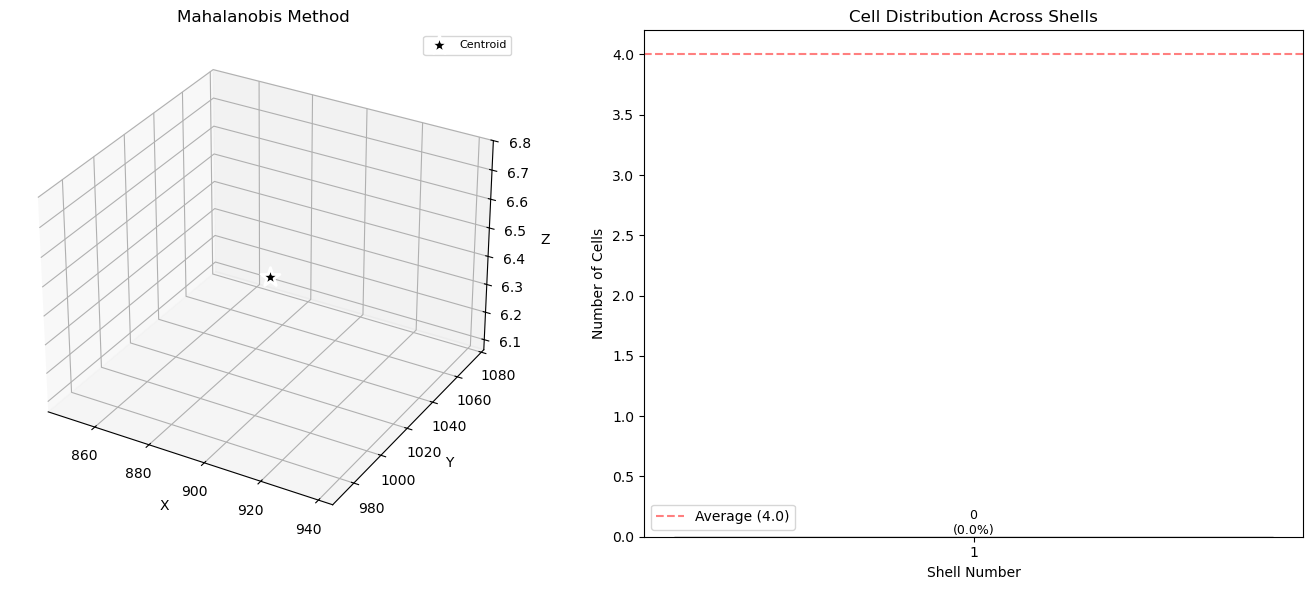

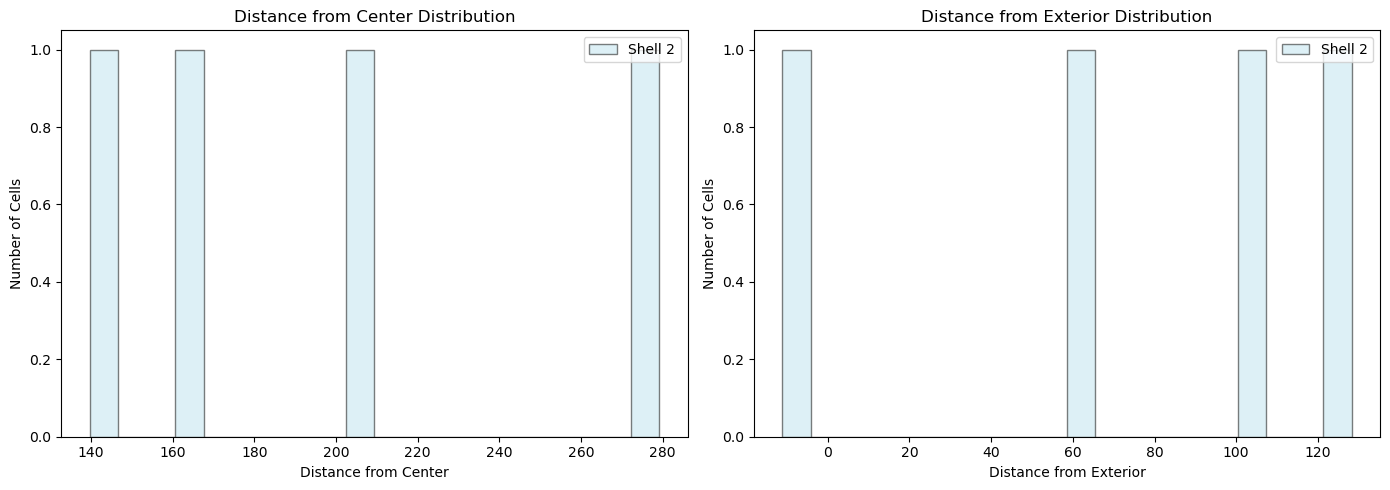

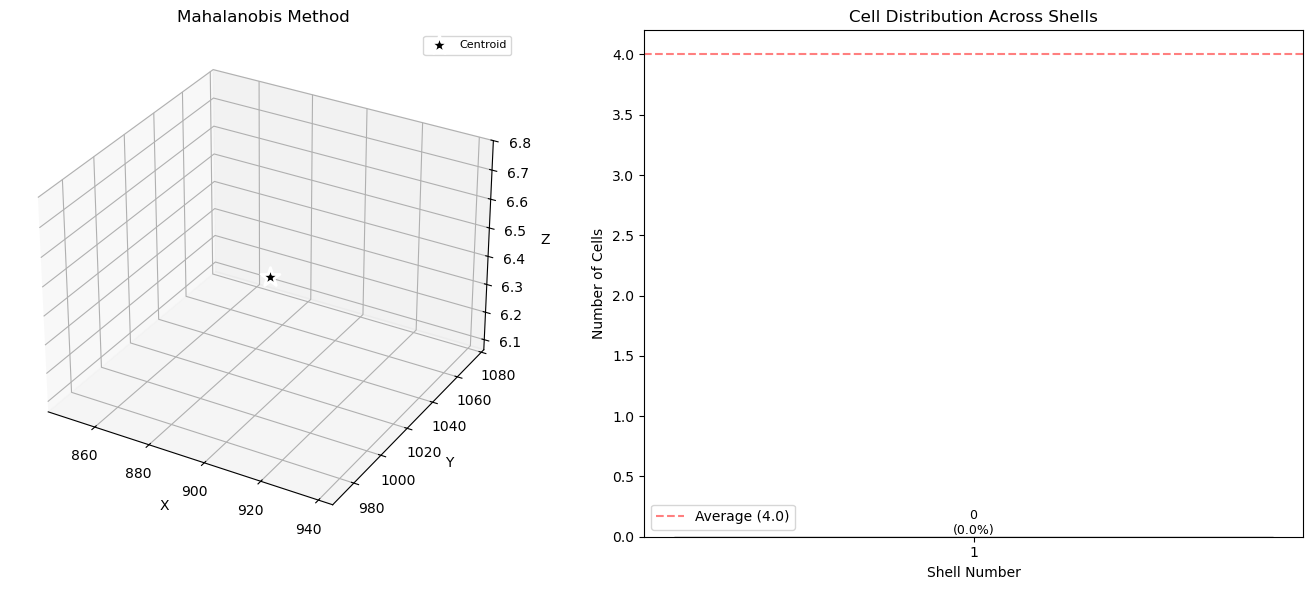

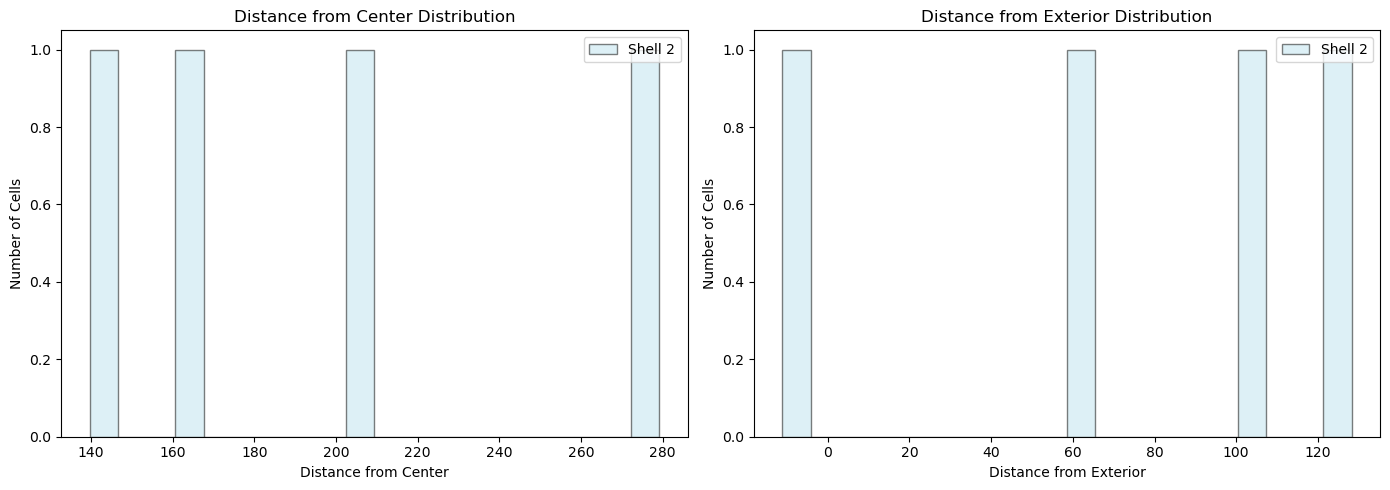

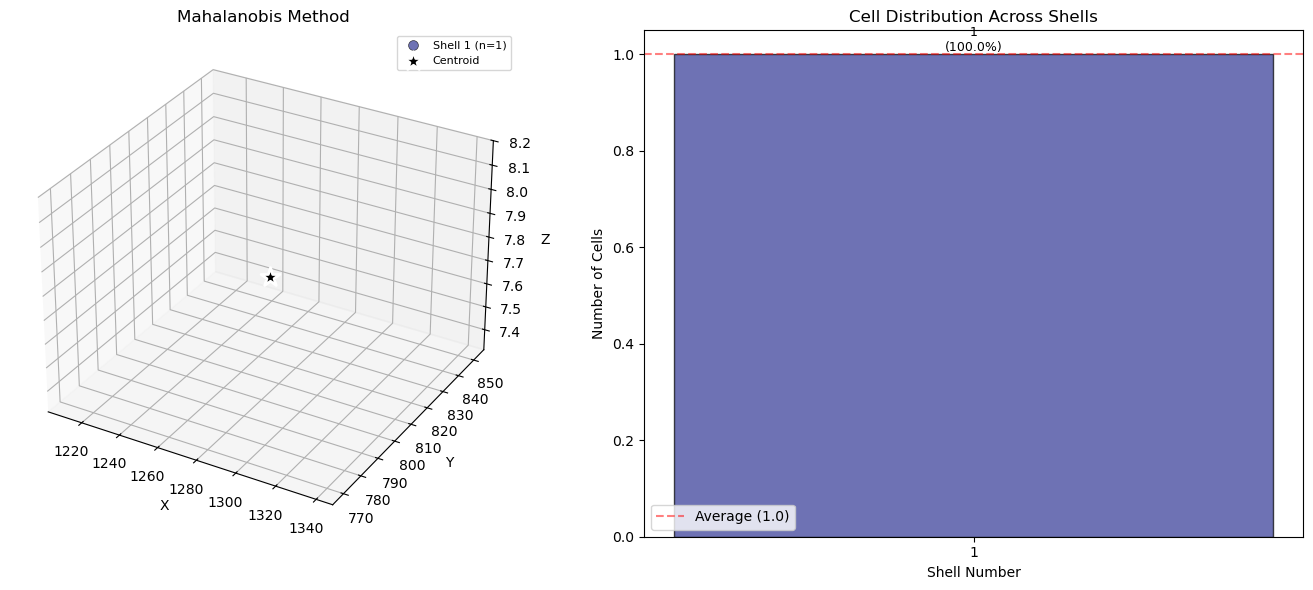

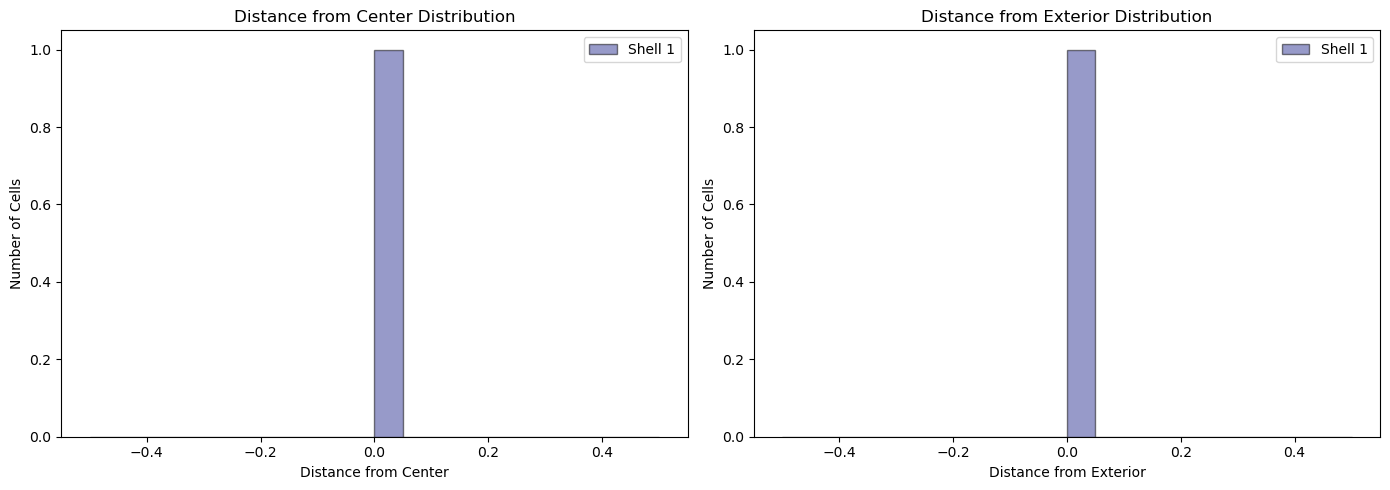

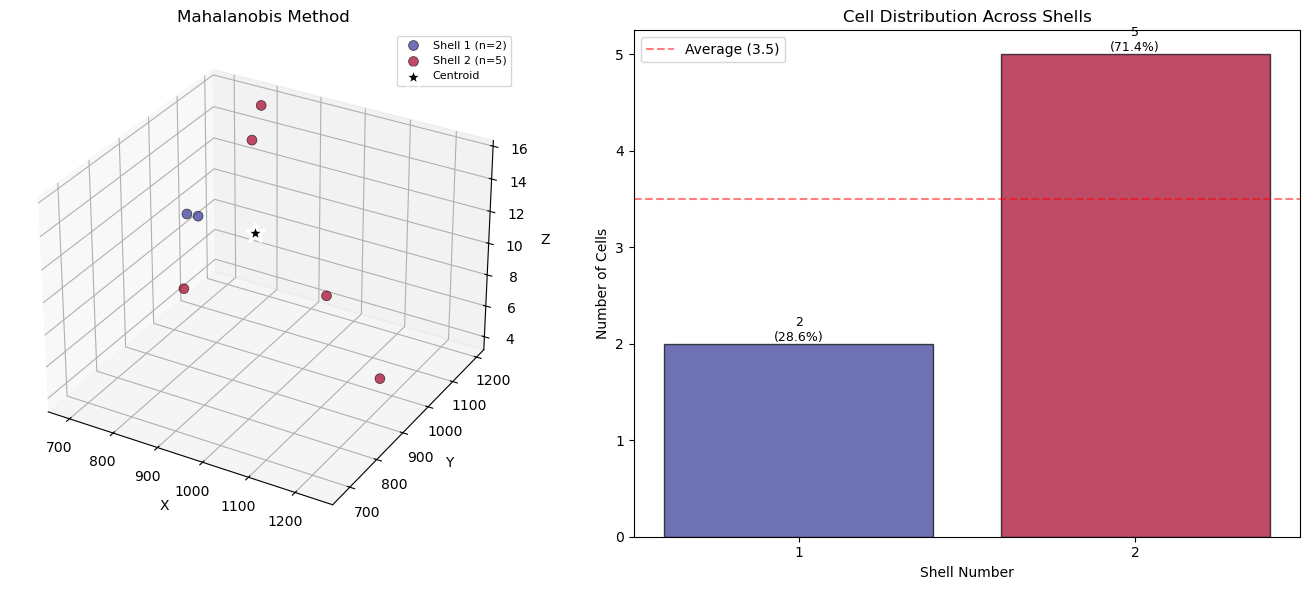

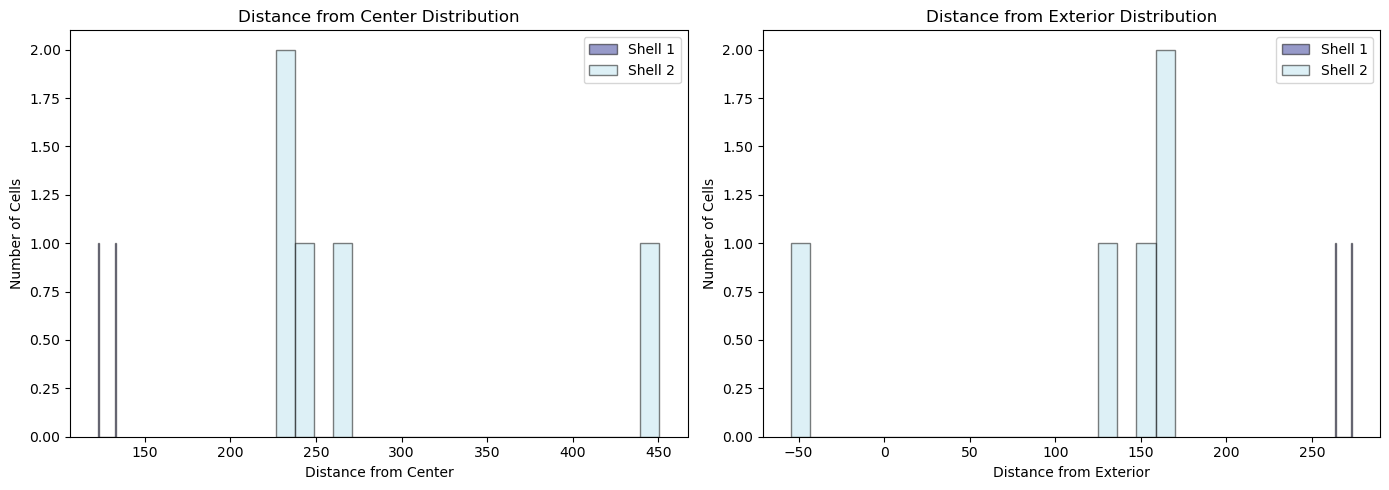

In [ ]:
dfs = []
for organoid_id in object_ids_dict.keys():
    print(
        f"Processing organoid ID: {organoid_id} with {len(object_ids_dict[organoid_id])} nuclei"
    )
    coords = get_coordinates(
        nuclei_mask=nuclei_mask, object_ids=object_ids_dict[organoid_id]
    )
    results, centroid = classify_cells_into_shells(
        coords, n_shells=N_SHELLS, method=METHOD
    )

    df = create_results_dataframe(results)
    dfs.append(df)
# show the last organoid's visualization as an example
if in_notebook and centroid is not None:
    fig1 = visualize_organoid_shells(
        coords, results, title=f"{METHOD.title()} Method", centroid=centroid
    )
    fig2 = plot_distance_distributions(results, N_SHELLS)

In [11]:
# merge the two dataframes
df = pd.concat(dfs, ignore_index=True)
merged_df = pd.merge(final_df, df, on="object_id", how="left")
for col in merged_df.columns:
    if "object_id" not in col and "neighbors" not in col and "image_set" not in col:
        merged_df.rename(columns={col: f"Neighbors_{col}"}, inplace=True)
merged_df.head()

,object_id,Neighbors_Neighbors_adjacent,Neighbors_Neighbors_10,Neighbors_shell_assignments,Neighbors_distances_from_center,Neighbors_distances_from_exterior,Neighbors_normalized_distances_from_center
0,47,0,0,1.0,279.095517,-11.108290,1.041451
1,47,0,0,1.0,279.095517,-11.108290,1.041451
2,47,0,0,1.0,268.887714,127.265209,0.678747
3,75,0,1,1.0,205.040251,62.946976,0.765112
4,75,0,1,1.0,205.040251,62.946976,0.765112


In [12]:
if not merged_df.empty:
    merged_df.insert(0, "image_set", image_set_loader.image_set_name)

output_file = pathlib.Path(
    output_parent_path
    / f"Neighbors_{compartment}_{channel}_{processor_type}_features.parquet"
)
output_file.parent.mkdir(parents=True, exist_ok=True)
merged_df.to_parquet(output_file)
merged_df.head()

,image_set,object_id,Neighbors_Neighbors_adjacent,Neighbors_Neighbors_10,Neighbors_shell_assignments,Neighbors_distances_from_center,Neighbors_distances_from_exterior,Neighbors_normalized_distances_from_center
0,D4-1,47,0,0,1.0,279.095517,-11.108290,1.041451
1,D4-1,47,0,0,1.0,279.095517,-11.108290,1.041451
2,D4-1,47,0,0,1.0,268.887714,127.265209,0.678747
3,D4-1,75,0,1,1.0,205.040251,62.946976,0.765112
4,D4-1,75,0,1,1.0,205.040251,62.946976,0.765112


In [13]:
end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
end_time = time.time()
get_mem_and_time_profiling(
    start_mem=start_mem,
    end_mem=end_mem,
    start_time=start_time,
    end_time=end_time,
    feature_type="Neighbors",
    well_fov=well_fov,
    patient_id=patient,
    channel=channel,
    compartment=compartment,
    CPU_GPU="CPU",
    output_file_dir=pathlib.Path(
        f"{root_dir}/data/{patient}/extracted_features/run_stats/{well_fov}_{channel}_{compartment}_Neighbors_CPU.parquet"
    ),
)


        Memory and time profiling for the run:

        Patient ID: NF0016_T1

        Well and FOV: D4-1

        Feature type: Neighbors

        CPU/GPU: CPU")

        Memory usage: 958.05 MB

        Time:

        --- %s seconds --- % 27.382503509521484

        --- %s minutes --- % 0.45637505849202475

        --- %s hours --- % 0.007606250974867079
    


True